# Low Light Image Denoiser

### Importing Libraries

In [38]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

### Function to Load Images from Directory

In [39]:
def load_images_from_directory(directory, size=(32, 32)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = img.resize(size)
            img = np.array(img) / 255.0
            images.append(img)
    return np.array(images)

In [40]:
train_noisy_dir='C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Train\\Noisy'
train_clean_dir='C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Train\\Clean'
test_noisy_dir='C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Test\\Noisy'
test_clean_dir='C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Test\\Clean'

In [41]:
train_noisy_images = load_images_from_directory(train_noisy_dir)
train_clean_images = load_images_from_directory(train_clean_dir)
test_noisy_images = load_images_from_directory(test_noisy_dir)
test_clean_images = load_images_from_directory(test_clean_dir)

In [61]:
print("Train Noisy Images Shape: ", train_noisy_images.shape)
print("Train Clean Images Shape: ", train_clean_images.shape)
print("Test Noisy Images Shape: ", test_noisy_images.shape)
print("Test Clean Images Shape: ", test_clean_images.shape)

Train Noisy Images Shape:  (437, 32, 32, 3)
Train Clean Images Shape:  (437, 32, 32, 3)
Test Noisy Images Shape:  (48, 32, 32, 3)
Test Clean Images Shape:  (48, 32, 32, 3)


In [43]:
train_noisy_images = train_noisy_images.astype('float64')
train_clean_images = train_clean_images.astype('float64')
test_noisy_images = test_noisy_images.astype('float64')
test_clean_images = test_clean_images.astype('float64')

### Denoising Model

In [21]:
def residual_block_lab(input_tensor, filters):
    x = Conv2D(filters, 3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, 1, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
def unet_model_with_residuals(input_size=(32, 32, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block_lab(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block_lab(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block_lab(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block_lab(conv4, 256)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = residual_block_lab(conv5, 128)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block_lab(conv6, 64)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block_lab(conv7, 32)

    conv8 = Conv2D(3, 1, activation='sigmoid')(conv7)  # Output layer with 3 channels

    model = Model(inputs=[inputs], outputs=[conv8])

    return model


In [23]:
model = unet_model_with_residuals((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.01, patience=15, min_lr=0.00000001)
]

history = model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=32, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

denoised_images = model.predict(test_noisy_images)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - loss: 0.0431 - val_loss: 0.2995 - learning_rate: 0.0100
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - loss: 0.0252 - val_loss: 0.3001 - learning_rate: 0.0100
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 0.0208 - val_loss: 0.2929 - learning_rate: 0.0100
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - loss: 0.0201 - val_loss: 0.2200 - learning_rate: 0.0100
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - loss: 0.0160 - val_loss: 0.2144 - learning_rate: 0.0100
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - loss: 0.0155 - val_loss: 0.1770 - learning_rate: 0.0100
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.0137 - val_loss: 0.2437 - learning_rate: 0.0100
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - loss: 0.0140 - val_loss: 0.1382 - learning_rate: 0.0100
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - loss: 0.0149 - val_loss: 0.0595 - learning_rate: 0.0100
Epoch 10/

### Training Model

In [10]:
history = model.fit(train_noisy_images, train_clean_images, epochs=200, batch_size=32, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - loss: 0.0542 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - loss: 0.0262 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0229 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 0.0214 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0193 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 0.0179 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.0197 - val_loss: 0.0509 - learning_rate: 0.0010
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.0169 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.0185 - val_loss: 0.0491 - learning_rate: 0.0010


### Testing Model

In [62]:
denoised_images = model.predict(test_noisy_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


### Function to Calculate PSNR

In [24]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

# Calculate PSNR, MSE, and MAE
psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 20.015675755813593
MSE: 0.01213605901971025
MAE: 0.09234347248873802


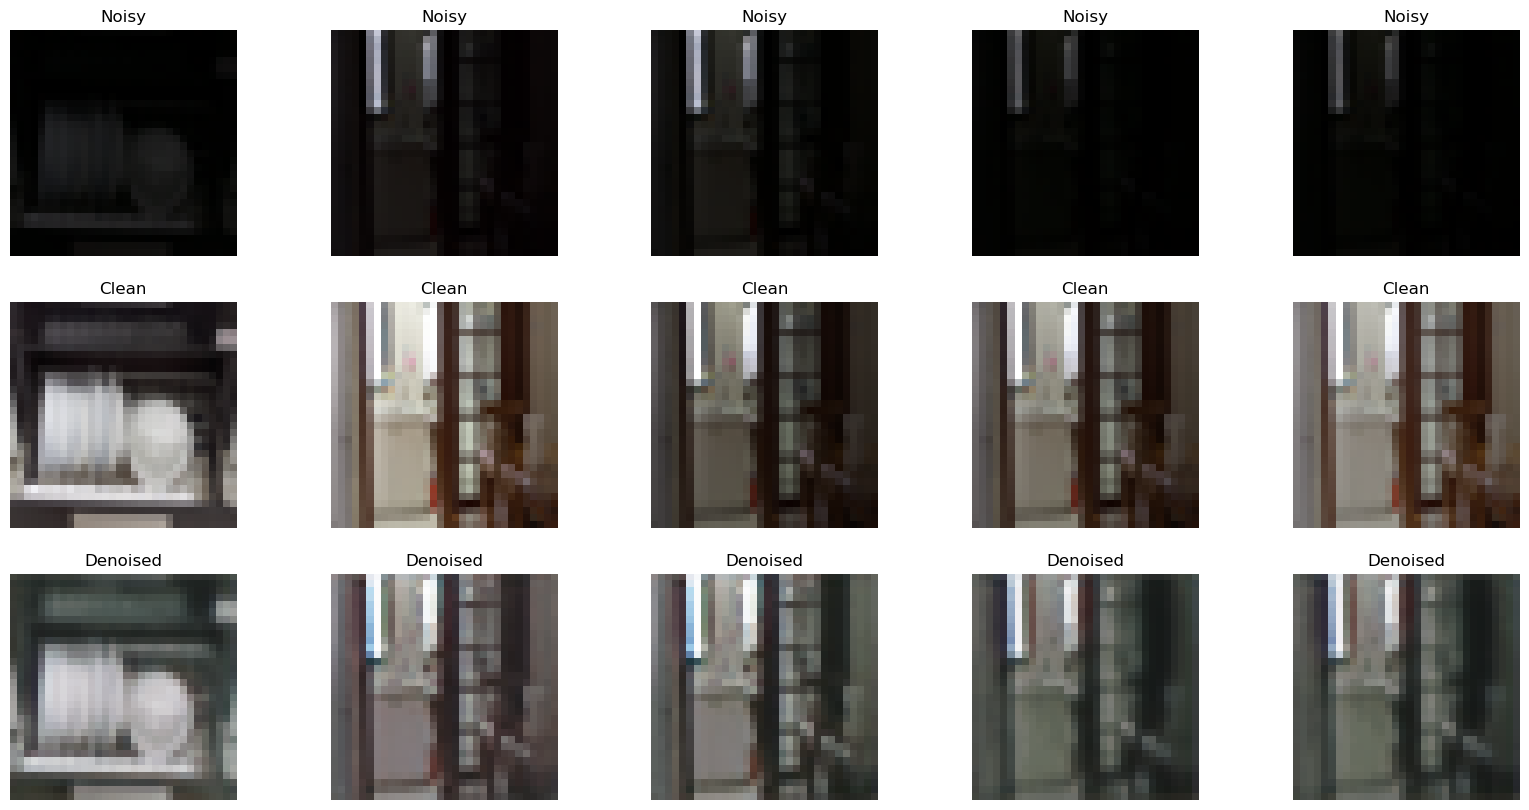

In [25]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_clean_images[i])
    plt.title("Clean")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()

### Function to Convert Images to their Normal Sizes

In [26]:
def load_images_from_directory(directory, size=(600, 400)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = img.resize(size)
            img = np.array(img) / 255.0
            images.append(img)
    return np.array(images)

In [27]:
test_noisy_images = load_images_from_directory(test_noisy_dir)
test_clean_images = load_images_from_directory(test_clean_dir)

In [28]:
from PIL import Image
import numpy as np

denoised_images_resized = []

for img_array in denoised_images:
    img = Image.fromarray((img_array * 255).astype(np.uint8))  # Ensure the image is in 0-255 range and uint8 type
    img_resized = img.resize((600, 400), Image.Resampling.LANCZOS)
    denoised_images_resized.append(np.array(img_resized))
    
denoised_images_resized = np.array(denoised_images_resized)

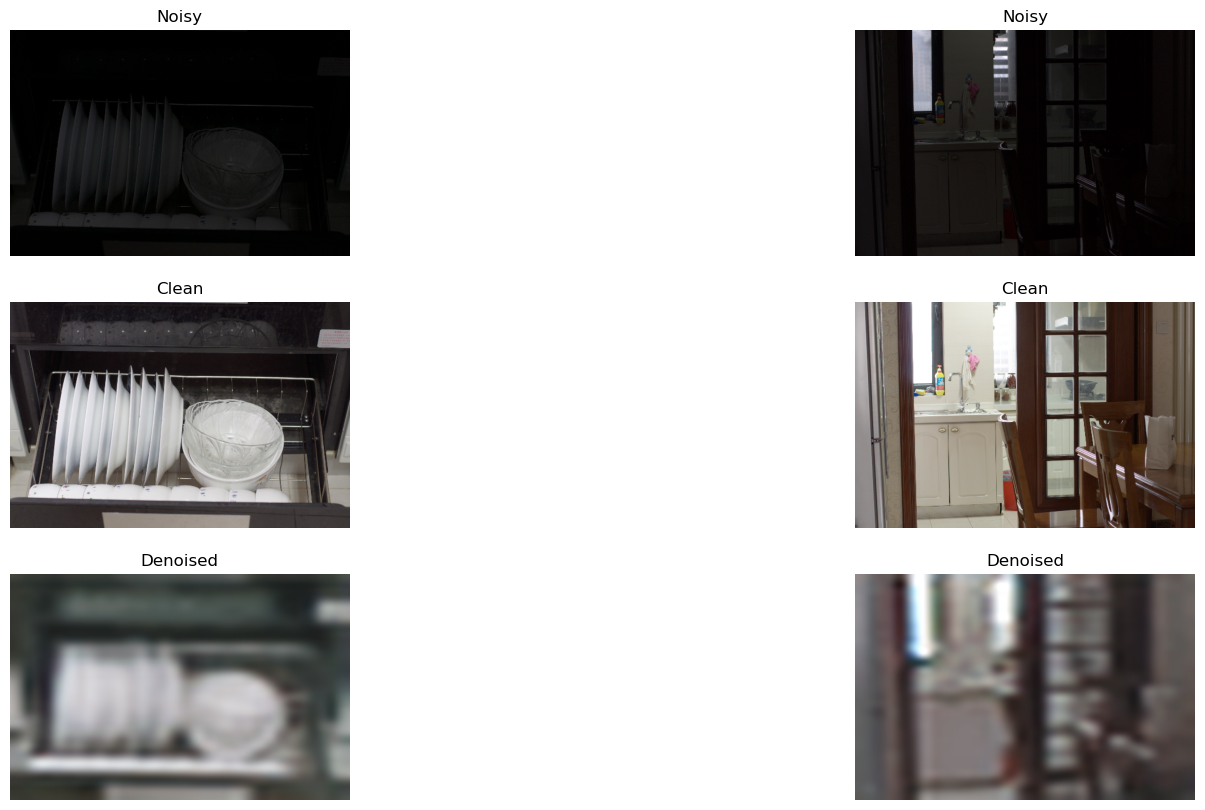

In [29]:
n = 2
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_clean_images[i])
    plt.title("Clean")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images_resized[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step/step - loss: 0.05
 - val_psnr: 5.61
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - loss: 0.0528 - val_loss: 0.2850 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step ep - loss: 0.0
 - val_psnr: 5.69
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0267 - val_loss: 0.2811 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step ep - loss: 0.0
 - val_psnr: 5.63
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.0247 - val_loss: 0.2789 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step ep - loss: 0.0
 - val_psnr: 5.75
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.0217 - val_loss: 0.2745 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step ep - loss: 0.0
 - val_psnr: 7.14
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - loss: 0.0190 - val_loss: 0.2123 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step ep - loss: 0.0
 - val_psnr: 6.32
14/14 ━━━━━

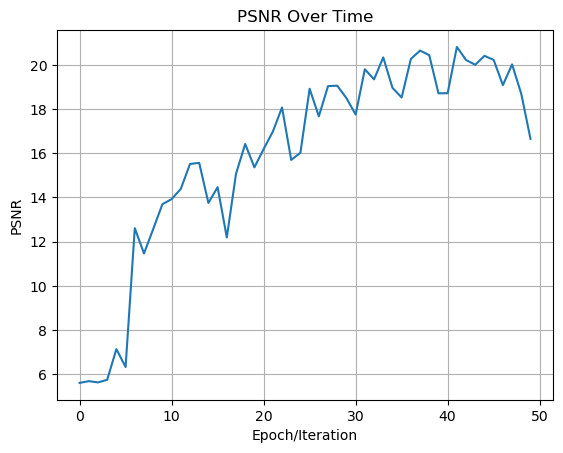

In [44]:
psnr_callback = PSNRCallback(validation_data=(test_noisy_images, test_clean_images))

model = unet_model_with_residuals((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, min_lr=0.000001),
    psnr_callback
]

history = model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=32, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

plot_metrics_over_time(psnr_callback.psnr_values, 'PSNR')


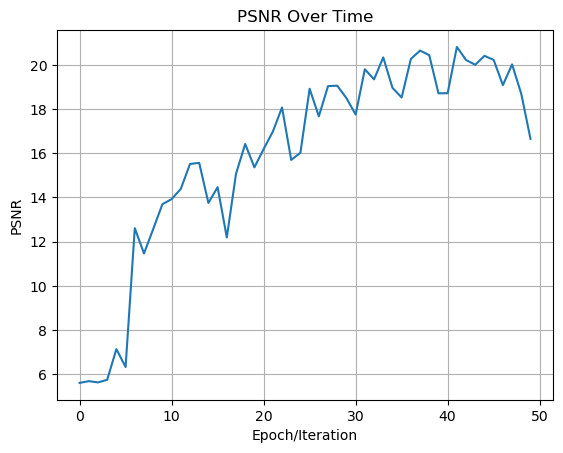

In [63]:
n = 2
def plot_metrics_over_time(metrics_values, metric_name):
    plt.plot(metrics_values)
    plt.title(f'{metric_name} Over Time')
    plt.xlabel('Epoch/Iteration')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

# Plot PSNR over time
plot_metrics_over_time(psnr_callback.psnr_values, 'PSNR')


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


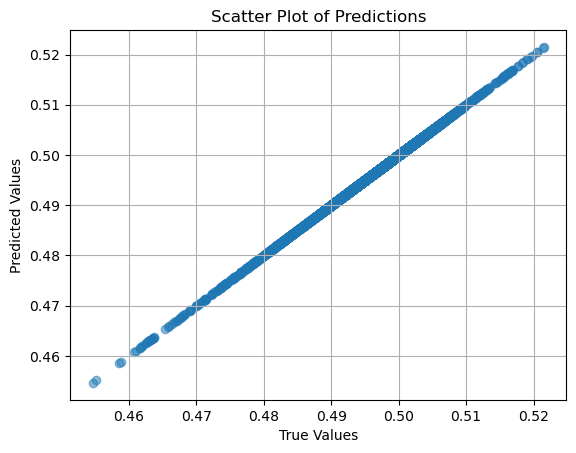

In [58]:
def plot_scatter_predictions(y_true, y_pred):
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.title('Scatter Plot of Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

# Example usage:
y_true = model.predict(test_noisy_images)
y_pred = model.predict(test_noisy_images)
plot_scatter_predictions(y_true, y_pred)